# ⚛️  PLA-Net: Predicting Protein-Ligand Interactions with Deep Graph Networks

Github repo: [PLA-Net](https://github.com/juliocesar-io/PLA-Net/tree/main)

## Background

**PLA-Net** is a deep learning model designed to predict interactions between small organic molecules (ligands) and any of the 102 target proteins in the Alzheimer's Disease (AD) dataset. By transforming molecular and protein sequences into graph representations, PLA-Net leverages Graph Convolutional Networks (GCNs) to analyze and predict target-ligand interaction probabilities. Developed by [BCV-Uniandes](https://github.com/BCV-Uniandes/PLA-Net).


## Setup

To run inference and training experiments with PLA-Net locally using a notebook. In the project folder, run the following command:

Expose a volume so you can share files with the host, also make sure to expose the ports and bind to the 0.0.0.0 to have external access if you are using a server.

```bash
docker run \
    -it --rm --gpus all \
    -p 8888:8888 \
    -v "$(pwd)":/home/user/app \
    pla-net:latest \
    jupyter lab --ip 0.0.0.0 --port 8888 
```

Weights are provided for quick inference under the `pretrained-models` folder. 



#### Test GPU is available

In [1]:
!nvidia-smi

Sat Sep 28 00:24:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:01:00.0 Off |                  Off |
| 30%   34C    P8              20W / 300W |      1MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import dependencies

In [2]:
import time
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch_geometric.data import DataLoader
from model.model_concatenation import PLANet
from utils.model import get_dataset_inference, test_gcn

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

## Inference
To run inference first prepare the input ligand SMILEs in as csv file, traing the target protein or use the provided target protein "ada": `O6 alkyl guanine transferase I` under `pretrained-models/BINARY_ada` checkpoints to test. 


### Generate the input file

In [4]:
import pandas as pd

# Create a dictionary with the SMILES data
data = {
    "smiles": [
        "Cn4c(CCC(=O)Nc3ccc2ccn(CC[C@H](CO)n1cnc(C(N)=O)c1)c2c3)nc5ccccc45",
        "OCCCCCn1cnc2C(O)CN=CNc12",
        "Nc4nc(c1ccco1)c3ncn(C(=O)NCCc2ccccc2)c3n4"
    ]
}

# Create a DataFrame from the dictionary
input_smiles_data_frame = pd.DataFrame(data)

# Save the DataFrame to a CSV file
file_path = "smiles_input.csv"
input_smiles_data_frame.to_csv(file_path, index=False)

input_smiles_data_frame

,smiles
0,Cn4c(CCC(=O)Nc3ccc2ccn(CC[C@H](CO)n1cnc(C(N)=O...
1,OCCCCCn1cnc2C(O)CN=CNc12
2,Nc4nc(c1ccco1)c3ncn(C(=O)NCCc2ccccc2)c3n4


### Visualize the input

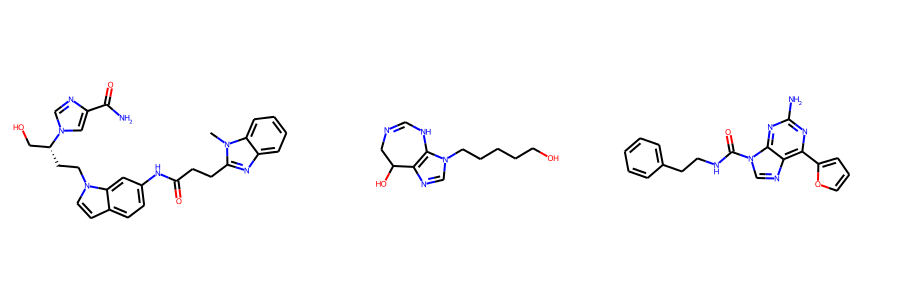

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw

# Convert SMILES to RDKit molecule objects
molecules = [Chem.MolFromSmiles(smile) for smile in input_smiles_data_frame["smiles"]]

# Generate the molecule images and display it in Jupyter
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300))
img

### Select the target protein

In [6]:
TARGET_PROTEIN_CODE = "ada"

target_list = "./Targets_Fasta.csv"
data_target = pd.read_csv(target_list, names=["Fasta", "Target", "Label"])
target_sequence = data_target[data_target['Target'] == TARGET_PROTEIN_CODE]
data_target

,Fasta,Target,Label
0,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,akt1,0
1,MLSNSQGQSPPVPFPAPAPPPQPPTPALPHPPAQPPPPPPQQFPQF...,mapk2,1
2,MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANT...,thrb,2
3,MWSWKCLLFWAVLVTATLCTARPSPTLPEQAQPWGAPVEVESFLVH...,fgfr1,3
4,MRALLARLLLCVLVVSDSKGSNELHQVPSNCDCLNGGTCVSNKYFS...,urok,4
...,...,...,...
97,MEQPQEEAPEVREEEEKEEVAEAEGAPELNGGPQHALPSSSYTDLS...,ppard,97
98,MENGYTYEDYKNTAEWLLSHTKHRPQVAIICGSGLGGLTDKLTQAQ...,pnph,98
99,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,abl1,99
100,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,cp2c9,100


### Prepare the inference dataset

#### Get input target sequence graph respresentation with torch gometric
Convert the target protein sequence into a graph representation

In [7]:
from torch_geometric.data import Data
from notebooks.data_preparation import protein_to_graph

sequence_string = target_sequence["Fasta"].values[0]
print(f"Input target sequence: {sequence_string}")

def process_input_protein(sequence_string: str):
    
    edge_attr_p, edge_index_p, x_p = protein_to_graph(sequence_string)
    x_p = torch.tensor(x_p)
    edge_index_p = torch.tensor(edge_index_p)
    edge_attr_p = torch.tensor(edge_attr_p)
    
    protein_graph = Data(edge_attr=edge_attr_p, edge_index=edge_index_p, x=x_p)
    
    print(f"Input Graph protein representation: {protein_graph}")

    return protein_graph

protein_graph = process_input_protein(sequence_string)

Input target sequence: MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGLLNVIGMDKPLTLPDFLAKFDYYMPAIAGCREAIKRIAYEFVEMKAKEGVVYVEVRYSPHLLANSKVEPIPWNQAEGDLTPDEVVALVGQGLQEGERDFGVKARSILCCMRHQPNWSPKVVELCKKYQQQTVVAIDLAGDETIPGSSLLPGHVQAYQEAVKSGIHRTVHAGEVGSAEVVKEAVDILKTERLGHGYHTLEDQALYNRLRQENMHFEICPWSSYLTGAWKPDTEHAVIRLKNDQANYSLNTDDPLIFKSTLDTDYQMTKRDMGFTEEEFKRLNINAAKSSFLPEDEKRELLDLLYKAYGMPPSASAGQNL
Input Graph protein representation: Data(x=[2869, 9], edge_index=[2, 5868], edge_attr=[5868, 3])


#### Build the inference dataset with the input ligands 
Next step is to add the input smiles list to the dataset converting each ligand into the graph representation alogside our `protein_graph`

In [8]:
from tqdm import tqdm
from rdkit import Chem
from notebooks.data_preparation import smiles_to_graph


def process_input_smile(smile_string: str):
    DEFAULT_LABEL = 0
    edge_attr, edge_index, x = smiles_to_graph(smile_string)
    x = torch.tensor(x)
    y = torch.tensor([DEFAULT_LABEL])
    edge_index = torch.tensor(edge_index)
    edge_attr = torch.tensor(edge_attr)
    
    mol = Chem.MolFromSmiles(smile_string)
    
    return Data(
        edge_attr=edge_attr, 
        edge_index=edge_index, 
        x=x, 
        y=y, 
        mol=mol, 
        smiles=smile_string
    )

def get_input_dataset():
    DEFAULT_LABEL = 0
    input_dataset = []
    
    for smiles in input_smiles_data_frame["smiles"]:
        smiles_graph = process_input_smile(smiles)
        input_dataset.append([smiles_graph, protein_graph])

    return input_dataset
get_input_dataset()

[[Data(x=[37, 9], edge_index=[2, 82], edge_attr=[82, 3], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x7570cd76e320>, smiles='Cn4c(CCC(=O)Nc3ccc2ccn(CC[C@H](CO)n1cnc(C(N)=O)c1)c2c3)nc5ccccc45'),
  Data(x=[2869, 9], edge_index=[2, 5868], edge_attr=[5868, 3])],
 [Data(x=[17, 9], edge_index=[2, 36], edge_attr=[36, 3], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x7570cd76dd20>, smiles='OCCCCCn1cnc2C(O)CN=CNc12'),
  Data(x=[2869, 9], edge_index=[2, 5868], edge_attr=[5868, 3])],
 [Data(x=[26, 9], edge_index=[2, 58], edge_attr=[58, 3], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x7570cd76e980>, smiles='Nc4nc(c1ccco1)c3ncn(C(=O)NCCc2ccccc2)c3n4'),
  Data(x=[2869, 9], edge_index=[2, 5868], edge_attr=[5868, 3])]]

#### Load the inference Dataset into the model


In [9]:
from torch_geometric.data import DataLoader
from notebooks.pla_net_model import PLANet
from notebooks.deeper_gcn import DeeperGCN

inference_data_loader = DataLoader(
    get_input_dataset(), 
    batch_size=10, 
    shuffle=False,
    num_workers=0
)

# Sample initialization parameters
hidden_channels_smiles = 128       # Hidden channels for the molecule network
hidden_channels_prot = 128         # Hidden channels for the protein network \ the dimension of embeddings of nodes and edges
nclasses = 2                       # Number of output classes, 2 for binary classification
norm = 'batch'                     # Normalization type (optional for MLP)


# Molecule and protein networks
molecule_gcn = DeeperGCN(hidden_channels_smiles, conv_encode_edge=True)
target_gcn = DeeperGCN(hidden_channels_prot, is_prot=True, num_layers_prot=20, mlp_layers_prot=3, hidden_channels_prot=hidden_channels_prot, conv_encode_edge_prot=False)


# Initialize the PLANet model
planet_model = PLANet(
    molecule_gcn,
    target_gcn,
    hidden_channels_smiles,
    hidden_channels_prot,
    nclasses,
    norm=norm
).to(device)
print(planet_model)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


The number of layers 20 Aggr aggregation method softmax block: res+
The number of layers 20 Aggr aggregation method softmax block: res+
PLANet(
  (molecule_gcn): DeeperGCN(
    (gcns): ModuleList(
      (0): GENConv()
      (1): GENConv()
      (2): GENConv()
      (3): GENConv()
      (4): GENConv()
      (5): GENConv()
      (6): GENConv()
      (7): GENConv()
      (8): GENConv()
      (9): GENConv()
      (10): GENConv()
      (11): GENConv()
      (12): GENConv()
      (13): GENConv()
      (14): GENConv()
      (15): GENConv()
      (16): GENConv()
      (17): GENConv()
      (18): GENConv()
      (19): GENConv()
    )
    (norms): ModuleList(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, 

#### Reference List of Model Parameters for the GCN
Handbook reference to play with the model

```bash
molecule_gcn = DeeperGCN(
    num_layers=20,                       # Number of layers in the GCN network (default: 20)
    mlp_layers=3,                        # Number of MLP layers in each GCN layer (default: 3)
    hidden_channels=128,                 # Dimension of hidden embeddings for nodes/edges (default: 128)
    msg_norm=False,                      # Whether to use message normalization in GCN layers (default: False)
    learn_msg_scale=False,               # Whether the message scale is learnable (default: False)
    conv_encode_edge=False,              # Whether to encode edge features within the convolution (default: False)
    dropout=0.2,                         # Dropout rate for layers to prevent overfitting (default: 0.2)
    block="res+",                        # Type of GCN block {res+, res, dense, plain} (default: "res+")
    add_virtual_node=False,              # Whether to add a virtual node in the graph (default: False)
    conv="gen",                          # Type of convolution (e.g., "gen" for generalized convolution) (default: "gen")
    aggr="softmax",                      # Aggregation method used in the GCN layer [mean, max, add, softmax] (default: "softmax")
    t=1.0,                               # Temperature parameter for softmax aggregation (default: 1.0)
    learn_t=False,                       # Whether the temperature parameter t is learnable (default: False)
    p=1.0,                               # Power parameter for PowerMean aggregation (default: 1.0)
    learn_p=False,                       # Whether the power parameter p is learnable (default: False)
    norm="batch",                        # Normalization type applied to layers ("batch", "layer") (default: "batch")
    graph_pooling="mean",                # Pooling method for graph-level representations ("sum", "mean", "max") (default: "mean")
    nclasses=102,                        # Number of output classes for the classification task (default: 102)

    # Protein-specific configurations (for networks involving proteins)
    num_layers_prot=20,                  # Number of layers in the protein GCN network (default: 20)
    mlp_layers_prot=3,                   # Number of MLP layers in each protein GCN layer (default: 3)
    hidden_channels_prot=128,            # Dimension of hidden embeddings for protein nodes/edges (default: 128)
    msg_norm_prot=False,                 # Whether to use message normalization for protein GCN layers (default: False)
    learn_msg_scale_prot=False,          # Whether the message scale for protein GCN layers is learnable (default: False)
    conv_encode_edge_prot=False,         # Whether to encode protein edge features within the convolution (default: False)
    saliency=False                       # Whether to backpropagate saliency through the atom features (default: False)
    is_prot=False                        # Whether to use protein mode
)
```

### Inference


In [10]:
from notebooks.inference_gcn import run_inference_model_gcn

# Set the pretrained model for the target protein, the folder should container the Folds and each "Best_Model.pth" files.
pre_trained_model_checkpoints_path = f"pretrained-models/BINARY_{TARGET_PROTEIN_CODE}/"

run_inference_model_gcn(
    model=planet_model,
    device=device,
    loader=inference_data_loader,
    use_prot=True,
    feature='full',
    num_features=2,
    target=TARGET_PROTEIN_CODE,
    output_file='output.csv',
    target_checkpoint_path=pre_trained_model_checkpoints_path
)


Iteration:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]


model_name: pretrained-models/BINARY_ada/Fold1/Best_Model.pth


NotImplementedError: Module [GENConv] is missing the required "forward" function